# T5 Model FineTuning #

In this notebook, I will be performing finetuning on the T5 Model. In brief, the T5 model is a pre-trained deep learning model that is based on the transformer-architecture. The T5's primary focus of application is in the field of Text-To-Text transformations i.e. Question-Answering, Translation, and Summarization. 

Our main task in this notebook will be to create a fine-tuned model that will take in an abstract from a research article, and generate a title based on the input information. 

We will be using a dataset found on kaggle from this link: https://www.kaggle.com/vetrirah/janatahack-independence-day-2020-ml-hackathon?select=train.csv

Quoted from the kaggle description:

**Topic Modeling for Research Articles
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process. Given the abstract and title for a set of research articles, predict the topics for each article included in the test set.**

Even though the purpose of the dataset is to predict the topics of the articles, we will only be using it for the primary purpose of fine-tuning our pretrained T5 model to generate a title for each input abstract text.

In [1]:
train_data_loc = "../data/Abstract-Research_Dataset/train.csv"
test_data_loc = "../data/Abstract-Research_Dataset/test.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
from torch.utils.data import random_split, RandomSampler
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
train_df = pd.read_csv(train_data_loc, encoding='utf-8')
test_df = pd.read_csv(test_data_loc, encoding='utf-8')

In [5]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [7]:
# Here we drop the columns that don't pertain to our task at hand

train_df.drop(columns=['ID','Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'], inplace=True)

test_df.drop(columns=['ID'], inplace=True)

The first thing I wanted to do was some exploratory data analysis. Primarily finding the distribution of word counts in all of our samples. The reason I do this is that due to memory constraints on my server I may run into an issue of running out of CUDA memory, which would impede my training. 

In [8]:
# Descr: To display plots and metrics regarding token quantity in given input text
# Arguements:
# =====================================================================
# arr1 - input array 1
# arr2 - input array 2
# show_distr - whether to show plots of distributions
# return_distr - whether to return distribution arrays
# =====================================================================

def DisplayMaxTokens(arr1, arr2, show_distr = False, return_distr = False):
    arr1_maxlen = 0
    arr2_maxlen = 0
    
    seq1_LenArr = []
    seq2_LenArr = []
    
    for seq1, seq2 in zip(arr1, arr2):
        seq1_text = len(str(seq1).split())
        seq2_text = len(str(seq2).split())
    
        seq1_LenArr.append(seq1_text) 
        seq2_LenArr.append(seq2_text)    
        
        if(seq1_text > arr1_maxlen):
            arr1_maxlen = seq1_text
        if(seq2_text > arr2_maxlen):
            arr2_maxlen = seq2_text
            
    print("Maximum number of tokens in Array1: ", arr1_maxlen)
    print("Maximum number of tokens in Array2: ", arr2_maxlen)
    
    if(show_distr == True):
        sns.displot(seq1_LenArr);
        sns.displot(seq2_LenArr);
        
    if(return_distr == True):
        return seq1_LenArr, seq2_LenArr

Maximum number of tokens in Array1:  40
Maximum number of tokens in Array2:  449


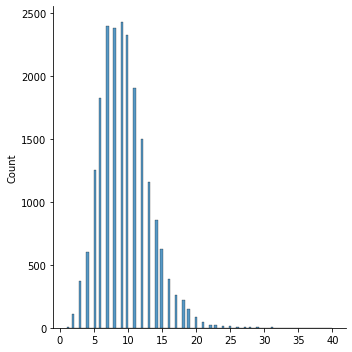

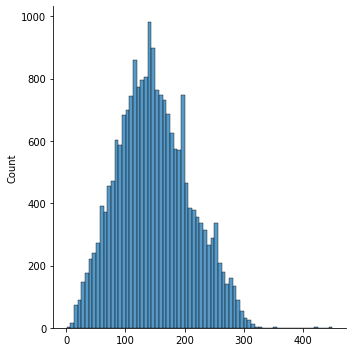

In [9]:
title_arr = train_df['TITLE']
abstract_arr = train_df['ABSTRACT']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=True, return_distr = True)

On seeing the above distributions we can see how our word count distribution is. To make sure my machine can handle the memory load I split the dataset such that we only consider the samples where the abstract is less than 200 words. Based on this we split both the training observations and the test observations.

In [10]:
train_df['abs_len'] = abstractlen_Arr

train_df = train_df[train_df['abs_len'] <= 200]

In [11]:
title_arr = test_df['TITLE']
abstract_arr = test_df['ABSTRACT']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=False, return_distr = True)
test_df['abs_len'] = abstractlen_Arr

test_df = test_df[test_df['abs_len'] <= 200]

Maximum number of tokens in Array1:  38
Maximum number of tokens in Array2:  391


In [12]:
train_df.reset_index()
train_df.head()

,TITLE,ABSTRACT,abs_len
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,76
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,99
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,110
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,125
6,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,105


In [13]:
test_df.reset_index()
test_df.head()

,TITLE,ABSTRACT,abs_len
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,96
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,135
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,126
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,119
5,Pairwise Difference Estimation of High Dimensi...,This paper proposes a regularized pairwise d...,101


In [14]:
title_arr = train_df['TITLE']
abstract_arr = train_df['ABSTRACT']

title_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', title) for title in title_arr]
abstract_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', abstract) for abstract in abstract_arr]

Here we declare our ResearchDataset Class which is inherited from Pytorch's DataSet class. An effective way of preparing and loading data. 

In [15]:
# Descr: Dataset class which is used to load our training data
# Constructor Arguements:
# =====================================================================
# title_arr - Array of article titles
# abstract_arr - Array of article abstracts
# tokenizer - Input tokenizer used to tokenize our text
# =====================================================================

class ResearchDataset(Dataset):
    def __init__(self, title_arr, abstract_arr, tokenizer):
        self.title_arr = title_arr
        self.abstract_arr = abstract_arr
        self.tokenizer = tokenizer 
        
        def ArrayLength():
            title_arr_length = len(self.title_arr)
            if(title_arr_length == len(self.abstract_arr)):
                return title_arr_length
            else:
                raise Exception("Array Lengths not Equal!!!")
                
        self.arr_len = ArrayLength()
        
    def __len__(self):
        return self.arr_len
    
    def __getitem__(self, index):
        title = self.title_arr[index]
        abstract = self.abstract_arr[index]
        
        input_ = abstract + " </s>"
        output_ = title + " </s>"
        
        #Encoding our inputs
        inputs = self.tokenizer.encode_plus(input_, pad_to_max_length=True,return_attention_mask=True, max_length=201)
        #Encoding our outputs
        outputs = self.tokenizer.encode_plus(output_, pad_to_max_length=True,return_attention_mask=True, max_length=41)
        
        input_ids = inputs['input_ids']
        input_attention_masks = inputs['attention_mask']
        
        output_ids = outputs['input_ids']
        output_attention_masks = outputs['attention_mask']
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'input_mask': torch.tensor(input_attention_masks, dtype=torch.long),
            'output_ids': torch.tensor(output_ids, dtype=torch.long),
            'output_mask': torch.tensor(output_attention_masks, dtype=torch.long)
        }   

In [16]:
# Loading pre-trained T5-base Tokenizer of T5-base Model

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device);

In [17]:
# Performing splitting of our Dataset in train and validation. Because we were already provided a Validation Dataset, we will not be splitting our train set here, hence our trainset_ratio = 1.0

research_dataset = ResearchDataset(title_arr, abstract_arr,tokenizer)

trainset_ratio = 1.0

data_len = len(research_dataset)
print("Total Data Size: ", data_len)

training_data_size = int(data_len*trainset_ratio)
print("Training Data Size: ", training_data_size)

val_data_size = data_len - training_data_size
print("Validation Data Size: ", val_data_size)

train_dataset, validation_dataset = random_split(research_dataset, [training_data_size, val_data_size])

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size=batch_size)

if(trainset_ratio != 1.0):
    validation_dataloader = DataLoader(validation_dataset, sampler = RandomSampler(validation_dataset), batch_size=batch_size)

Total Data Size:  16807
Training Data Size:  16807
Validation Data Size:  0


In [18]:
# Our actual Process of fine-tuning is done here

LEARNING_RATE = 1e-05

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

epochs = 1
steps2report = 500

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

for epoch in range(0,epochs):
    model.train()
    for step, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # Getting input parameters
        x_input_ids = data['input_ids'].to(device)
        x_masks = data['input_mask'].to(device)

        # Getting output parameters
        y_expl_ids = data['output_ids'].to(device)

        # Feeding values into our model
        outputs = model(input_ids              = x_input_ids, 
                        attention_mask         = x_masks,
                        labels                 = y_expl_ids)
        loss = outputs[0] 
        
        if step%steps2report==0:
            print("EPOCH: ", epoch, " loss.item: ", loss.item())
        
        loss.backward()
        optimizer.step() 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ubuntu/anaconda3/envs/test/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/ubuntu/anaconda3/envs/test/lib/python3.8/site-packages/transformers/mode

EPOCH:  0  loss.item:  12.471362113952637
EPOCH:  0  loss.item:  1.1752701997756958
EPOCH:  0  loss.item:  1.2249319553375244


The following column I commented out, but this is the code for saving our fine-tuned model locally.

In [19]:
#model_repository = "../trained_models/"
#model_name = "FineTuned_T5_Title_Abstract"

#model.save_pretrained(model_repository+model_name)

In [20]:
#tokenizer = T5Tokenizer.from_pretrained('t5-base')
#model = T5ForConditionalGeneration.from_pretrained("../trained_models/FineTuned_T5_Title_Abstract");
#model.to(device);

### Validation ###

Now that the process of fine-tuning is over, we can now get to the process of validation. We start out by pre-processing our test dataframes and creating our Test-ResearchDataSet and Test-DataLoader. After this we then go through our validation loop where we generate a prediction from each input_id and input_mask, we then store that prediction in model_outputArr, and the expected predictions in target_outputArr.

In [29]:
title_arr = test_df['TITLE']
abstract_arr = test_df['ABSTRACT']

title_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', title) for title in title_arr]
abstract_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', abstract) for abstract in abstract_arr]

batch_size = 32
testresearch_dataset = ResearchDataset(title_arr, abstract_arr, tokenizer)
test_dataloader = DataLoader(testresearch_dataset, sampler = RandomSampler(testresearch_dataset), batch_size=batch_size)

In [30]:
import torch
model.eval()

model_inputArr = []
model_outputArr = []
target_outputArr = []

with torch.no_grad():
    for step, data in enumerate(test_dataloader):
        input_ids = data["input_ids"].to(device)
        input_masks = data["input_mask"].to(device)
        explanation_ids = data["output_ids"].to(device)
        explanation_masks = data["output_mask"].to(device)
        output = model.generate(input_ids = input_ids, attention_mask = input_masks, max_length=200,do_sample=False )
        
        for input_vector, output_vector in zip(input_ids, output):
            model_inputArr.append(tokenizer.decode(input_vector, skip_special_tokens=True))
            model_outputArr.append(tokenizer.decode(output_vector, skip_special_tokens=True))
        target_outputArr.append(tokenizer.batch_decode(explanation_ids, skip_special_tokens=True))    
        
target_outputArr = [item for sublist in target_outputArr for item in sublist]

In [31]:
# Creating a new dataframe that contains our input, model predicted outout, and expected target output

data_ = {
    'input' : model_inputArr,
    'model output' : model_outputArr,
    'target output' : target_outputArr
}
results_dataframe = pd.DataFrame(data = data_)

In [32]:
results_dataframe.head()

,input,model output,target output
0,We present an active physical implementation o...,Active physical implementation of the plasmon ...,Active plasmon injection scheme for subdiffrac...
1,A plausible mechanism of selfregulation in tec...,Selfregulation in chain of processing,A Bottleneck Principle for TechnoMetabolic Chains
2,Training generative adversarial networks is un...,Training generative adversarial networks again...,Stabilizing GAN Training with Multiple Random ...
3,This paper enlarges classical syllogistic logi...,A logical system with a syllogistic logic,Syllogistic Logic with Cardinality Comparisons...
4,The excellent electronic and mechanical proper...,Flexible graphene based Hall sensors,Flexible Hall Sensors Based on Graphene


### BLEU Evaluation ###

Now that we have our predictions, we can evaluate the quality of our predictions based on the Bi-Lingual Evaluation Understudy(BLEU). In brief, we compare our generated sentences with our target sentences by counting the matching n-grams. In layman's terms, how well individual segment texts match from our predicted text to the expected text.

In [34]:
bleu_scores = []

for model_output, target_output in zip(model_outputArr, target_outputArr):
    model_token_arr = model_output.split();
    target_token_arr = model_output.split();

    score = sentence_bleu([target_token_arr], model_token_arr)

    bleu_scores.append(score)
    
print("Average Bleu Score: ", np.mean(bleu_scores))

Average Bleu Score:  0.9615653389238294
